In [4]:
import os
import sys
from  dotenv import load_dotenv
import psycopg2
import pandas as pd 
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans               
from sklearn.preprocessing import MinMaxScaler   
from sklearn.impute import SimpleImputer         

In [2]:
load_dotenv()
user = os.environ['user']
password = os.environ['password']
host = os.environ['host']
port = os.environ['port']
database = os.environ['database']

In [3]:
def connect():
    conn = None
    try:
        print('Connecting...')
        conn = psycopg2.connect(
            host = host,
            database = database,
            user = user,
            password = password
        )
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        sys.exit(1)

    print("All good, Connection successfull!")
    return conn

In [4]:
def sql_dataFrame(conn, query):
    cursor = conn.cursor()
    try:
        cursor.execute(query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    tuples_list = cursor.fetchall()

    df = pd.DataFrame(tuples_list, columns=[col[0] for col in cursor.description])
    cursor.close()
    return df


In [5]:
query = """ SELECT * FROM public.xdr_data"""

conn = connect()

df = sql_dataFrame(conn, query)

conn.close()

Connecting...
All good, Connection successfull!


In [6]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [7]:
# session Frequency
session_frequency = df.groupby(by=['MSISDN/Number'])['Dur. (ms)'].transform('count')
len(session_frequency)

150001

In [8]:
Session_Duration = df['Dur. (ms)']
len(Session_Duration)

150001

In [9]:
df['Total Data Usage'] = df['Total UL (Bytes)'] + df['Total DL (Bytes)']
df['Session Duration'] = df['Dur. (ms)']

grouped_data = df.groupby('MSISDN/Number').agg({
    'Total Data Usage': 'sum',
    'Session Duration': 'sum'
})


sorted_data = grouped_data.sort_values(by='Total Data Usage', ascending=False)
top_10_customers = sorted_data.head(10)
print(top_10_customers) 

               Total Data Usage  Session Duration
MSISDN/Number                                    
3.361489e+10       8.846226e+09         9966898.0
3.376054e+10       8.514774e+09         9279434.0
3.362578e+10       8.499621e+09        18553754.0
3.362632e+10       7.971167e+09         8791927.0
3.367588e+10       7.891111e+09         4865947.0
3.365973e+10       7.705863e+09         4035428.0
3.366646e+10       7.308501e+09         4536757.0
3.376041e+10       7.132371e+09         5321667.0
3.366471e+10       6.872018e+09         2927785.0
3.369879e+10       6.540899e+09         5169128.0


In [11]:
# Select the engagement metrics for clustering
engagement_metrics = ['Total Data Usage', 'Session Duration']


imputer = SimpleImputer(strategy='mean')
df[engagement_metrics] = imputer.fit_transform(df[engagement_metrics])
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[engagement_metrics])
             
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_scaled)
df['Cluster'] = kmeans.labels_

print(df[['MSISDN/Number', 'Cluster']])

c:\Users\Abdilfatah\Desktop\10Academy\week-2\myenv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Abdilfatah\Desktop\10Academy\week-2\myenv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


        MSISDN/Number  Cluster
0        3.366496e+10        1
1        3.368185e+10        0
2        3.376063e+10        1
3        3.375034e+10        0
4        3.369980e+10        2
...               ...      ...
149996   3.365069e+10        2
149997   3.366345e+10        0
149998   3.362189e+10        2
149999   3.361962e+10        2
150000            NaN        2

[150001 rows x 2 columns]


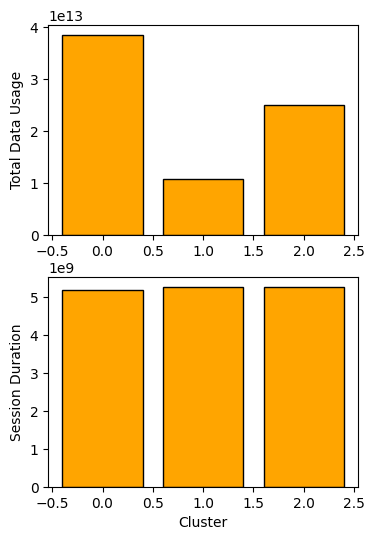

        Total Data Usage                                           \
                     min          max          mean           sum   
Cluster                                                             
0            639717108.0  955984776.0  7.791356e+08  3.853371e+13   
1             28956107.0  357391855.0  2.145687e+08  1.081147e+13   
2            357391573.0  639690566.0  4.988339e+08  2.502001e+13   

        Session Duration                                          
                     min        max           mean           sum  
Cluster                                                           
0                 7146.0  1859327.0  104511.267343  5.168814e+09  
1                 7189.0  1859336.0  104545.255165  5.267722e+09  
2                 7142.0  1772931.0  104768.090986  5.254853e+09  


In [12]:
cluster_metrics = df.groupby('Cluster')[engagement_metrics].agg(['min', 'max', 'mean', 'sum'])



# Plot the metrics summary
fig, axes = plt.subplots(len(engagement_metrics), 1, figsize=(4, 6))

for i, metric in enumerate(engagement_metrics):
    
    axes[i].bar(cluster_metrics.index, cluster_metrics[metric]['sum'], color='orange',ec ='black')
    
    axes[i].set_ylabel(metric)
plt.xlabel('Cluster')
plt.show()

print(cluster_metrics)

In [13]:
apps = ['Social Media DL (Bytes)','Social Media UL (Bytes)','Google DL (Bytes)','Google UL (Bytes)','Email DL (Bytes)','Email UL (Bytes)','Youtube DL (Bytes)','Youtube UL (Bytes)','Netflix DL (Bytes)','Netflix UL (Bytes)','Gaming DL (Bytes)','Gaming UL (Bytes)', 'Other DL (Bytes)','Other UL (Bytes)']
total_traffic_user = df.groupby('MSISDN/Number')[apps].sum()

top10_apps = {}
for i in apps:
    top10_apps[i] = total_traffic_user.nlargest(10, i)

for i, top_10_users in top10_apps.items():
    print(f"Top 10 users for {i}:")
    print(top_10_users)

Top 10 users for Social Media DL (Bytes):
               Social Media DL (Bytes)  Social Media UL (Bytes)  \
MSISDN/Number                                                     
3.362632e+10                42743837.0                 630942.0   
3.376054e+10                39297646.0                 485543.0   
3.365973e+10                34900444.0                 511914.0   
3.361489e+10                27749744.0                 544800.0   
3.362578e+10                26564121.0                 571379.0   
3.366716e+10                23753753.0                 494097.0   
3.378632e+10                23568655.0                 406264.0   
3.366907e+10                23477047.0                 323787.0   
3.360313e+10                22776679.0                 301146.0   
3.365849e+10                22695673.0                 304393.0   

               Google DL (Bytes)  Google UL (Bytes)  Email DL (Bytes)  \
MSISDN/Number                                                           
3.36263

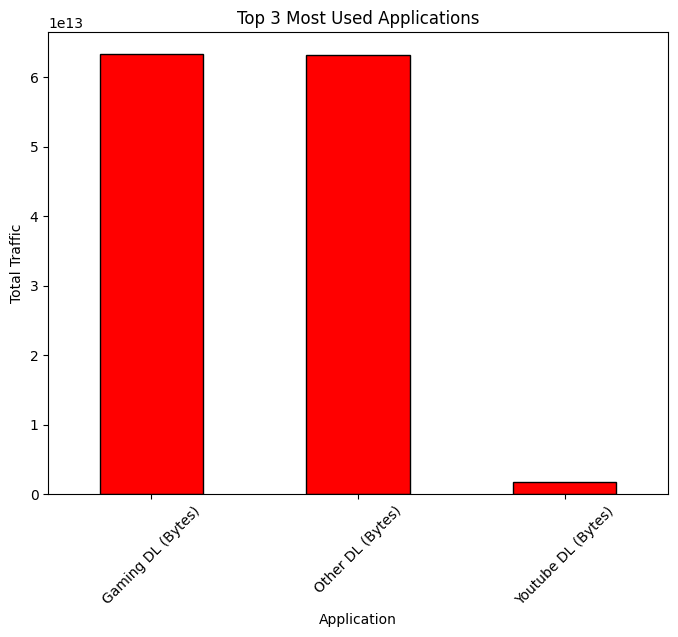

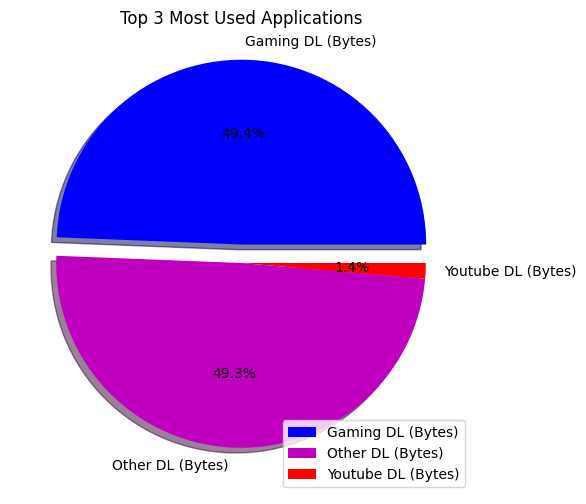

In [14]:
total_traffic_per_application = df[apps].sum()

top3_applications = total_traffic_per_application.nlargest(3)

plt.figure(figsize=(8, 6))
top3_applications.plot(kind='bar',color = 'red',ec ='black')
plt.xlabel('Application')
plt.ylabel('Total Traffic')
plt.title('Top 3 Most Used Applications')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(6, 6))
my_explode = [0.1, 0, 0]
my_colors = ["b", "m", "r"]
top3_applications.plot(kind='pie', autopct='%1.1f%%',shadow =True,explode=my_explode, colors=my_colors)
plt.title('Top 3 Most Used Applications')


plt.legend()
plt.show()